### Python import

In [1]:
import librosa
from tqdm import tqdm_notebook as tqdm
import os
import os.path as pth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
# import keras
from glob import glob
from scipy.io import wavfile

In [2]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, \
                                    BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, 
                                     GlobalAvgPool1D, Multiply, GlobalMaxPool1D,
                                     Dense, Dropout, Activation, Reshape, 
                                     Input, Concatenate, Add)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

In [4]:
from IPython.display import clear_output

In [5]:
plt.rcParams.update({'font.size': 16})

In [6]:
# os.environ['CUDA_VISIBLE_DEVICES'] = str(config['gpu_num'])
os.environ['CUDA_VISIBLE_DEVICES'] = str(5)
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [7]:
model_name = 'baseline_sampleCNN-original'

In [8]:
model_path = 'model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [9]:
print('Pandas: %s'%(pd.__version__))
print('Numpy: %s'%(np.__version__))
print('Scipy: %s'%(scipy.__version__))
print('Tensorflow: %s'%(tf.__version__))
print('Keras: %s'%(keras.__version__))

Pandas: 0.25.3
Numpy: 1.18.1
Scipy: 1.4.1
Tensorflow: 2.1.0
Keras: 2.2.4-tf


### Load Data

In [10]:
# wav 파일로부터 데이터를 불러오는 함수, 파일 경로를 리스트 형태로 입력
def data_loader(files):
    out = []
    for file in tqdm(files):
        fs, data = wavfile.read(file)
        out.append(data)    
    out = np.array(out)
    return out

In [11]:
# Wav 파일로부터 Feature를 만듭니다.
x_data = glob('data/train/*.wav')
x_data = data_loader(x_data)
x_data = np.asarray([wav/wav.max() for wav in x_data]) # 최대값을 나누어 데이터 정규화
x_data = x_data.reshape(x_data.shape[0], x_data.shape[1], 1) # CNN 모델에 넣기 위한 데이터 shape 변경

# 정답 값을 불러옵니다
y_data = pd.read_csv('data/train_answer.csv', index_col=0)
y_labels = y_data.columns.values
y_data = y_data.values

# Feature, Label Shape을 확인합니다.
x_data.shape, y_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


((100000, 16000, 1), (100000, 30))

### Training

In [12]:
input_shape = (x_data.shape[1], x_data.shape[2])
output_size = len(y_labels)

In [13]:
def build_cnn(input_shape, drop_rate=0.5, output_size=16):
    model=Sequential()
    
    # Layer 1
    model.add(Conv1D (kernel_size=3, filters=128, strides=3, padding='valid',
                      kernel_initializer='he_uniform', input_shape=input_shape))                  
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Layer 2
    model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 3
    model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 4
    model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 5
    model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 6
    model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 7
    model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 8
    model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3))

    # # Layer 9
    # model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu'))
    # model.add(MaxPooling1D(pool_size=3, strides=3))

    # # Layer 10
    # model.add(Conv1D (kernel_size=3, filters=512, padding='same', kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu'))
    # model.add(MaxPooling1D(pool_size=3, strides=3))

    # Layer 11
    model.add(Dropout(drop_rate))
    model.add(Flatten())

    # Layer 12
    model.add(Dense(output_size))
    model.add(Activation('softmax'))
    return model

In [14]:
model = build_cnn(input_shape=input_shape, output_size=output_size)
model.summary(line_length=150)
del model

Model: "sequential"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
conv1d (Conv1D)                                                    (None, 5333, 128)                                           512                    
______________________________________________________________________________________________________________________________________________________
batch_normalization (BatchNormalization)                           (None, 5333, 128)                                           512                    
______________________________________________________________________________________________________________________________________________________
activation (Activation)                                            (None, 

In [15]:
model = build_cnn(input_shape=input_shape, output_size=output_size)
model.compile(loss=tf.keras.losses.KLDivergence(), optimizer='adam')

# Validation 점수가 가장 좋은 모델만 저장합니다.
checkpoint_path = pth.join(model_path, model_name)
os.makedirs(checkpoint_path, exist_ok=True)
model_file_path = pth.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델을 학습시킵니다.
history = model.fit(
    x_data, y_data, 
    epochs=100, batch_size=64, validation_split=0.2, shuffle=True,
    callbacks=[checkpoint, early_stopping]
)

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
79936/80000 [============================>.] - ETA: 0s - loss: 1.9020
Epoch 00001: val_loss improved from inf to 1.70368, saving model to model/baseline_sampleCNN-original/Epoch_001_Val_1.704.hdf5
80000/80000 [==============================] - 146s 2ms/sample - loss: 1.9019 - val_loss: 1.7037
Epoch 2/100
79936/80000 [============================>.] - ETA: 0s - loss: 1.5653
Epoch 00002: val_loss improved from 1.70368 to 1.46531, saving model to model/baseline_sampleCNN-original/Epoch_002_Val_1.465.hdf5
80000/80000 [==============================] - 143s 2ms/sample - loss: 1.5653 - val_loss: 1.4653
Epoch 3/100
79936/80000 [============================>.] - ETA: 0s - loss: 1.4443
Epoch 00003: val_loss improved from 1.46531 to 1.46485, saving model to model/baseline_sampleCNN-original/Epoch_003_Val_1.465.hdf5
80000/80000 [==============================] - 144s 2ms/sample - loss: 1.4444 - val_loss: 1.4649
Epoch 4/100
79936/80000 

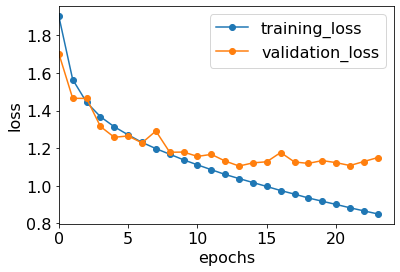

In [16]:
# 훈련 결과를 확인합니다.
plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Predict

In [17]:
submission_base = pth.join('submission')
os.makedirs(submission_base, exist_ok=True)

In [18]:
# 검증 wav 파일로부터 Feature를 만듭니다.
x_test = glob('data/test/*.wav')
x_test = data_loader(x_test)
x_test = np.asarray([wav/wav.max() for wav in x_test]) # 최대값을 나누어 데이터 정규화
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# 가장 좋은 모델의 weight를 불러옵니다.
checkpoint_path = pth.join(model_path, model_name)
weigth_file = glob('{}/*.hdf5'.format(checkpoint_path))[-1]
print(weigth_file)
model.load_weights(weigth_file)

# 예측 수행
y_pred = model.predict(x_test)

# 예측 결과로 제출 파일을 생성합니다.
submission = pd.read_csv('data/submission.csv', index_col=0)
submission.loc[:, :] = y_pred
submission.to_csv(pth.join(submission_base, '{}.csv'.format(model_name)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



model/baseline_sampleCNN-original/Epoch_014_Val_1.105.hdf5
